#### Import all libraries

In [1]:
from __future__ import print_function
import os
import collections
import SimpleITK as sitk
import numpy as np
import six
import radiomics
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm, getTestCase
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import logging as logger
import time
import json
import os
import logging.config
import pandas as pd
import gc

In [2]:
#Read the entire Benthiemer sandstone
global image_1, label_1
filename_ben = 'investigate_bent_8bit.nrrd'
image_1 = sitk.ReadImage('D:\\Ankita\\pyradiomics\\data\\investigate_bent_8bit.nrrd')

#### Extraction Settings

In [3]:
settings = {}
settings['label'] = 255

In [4]:
%%time
mask_x = 520
mask_y = 520
mask_z = 520
global window_size, total_iter, expect_iter, i_loc, j_loc, z_loc, bb, correctedMask, croppedImage, croppedMask, glcm_window
for window_size in range(20,301,20):
    expect_iter = (mask_x - window_size + 1)**3
    print("Expected Calculations for Window", str(window_size), ". The expected of iterations is ", str(expect_iter))        
    glcm_window = np.zeros((expect_iter,1))
    total_iter = 0
    for i_loc in range(mask_x-window_size+1):
        for j_loc in range(mask_y-window_size+1):
            for z_loc in range(mask_z-window_size+1):           
                full_mask = np.zeros((520, 520, 520), dtype = np.uint8)
                full_mask[i_loc:i_loc+window_size,j_loc:j_loc+window_size,z_loc:z_loc+window_size] = 255

                outputFileName = 'rock_label_w_' + str(window_size) + '_xloc_' + str(i_loc) + '_yloc_' + str(j_loc) + '_zloc_' + str(z_loc)+ '.nrrd'
                nrrd.write(outputFileName, full_mask)

                #import the mask
                label_1 = sitk.ReadImage(outputFileName)
                del full_mask
                
                bb, correctedMask = imageoperations.checkMask(image_1, label_1, label=255)
                if correctedMask is not None:
                    label_1 = correctedMask
                croppedImage, croppedMask = imageoperations.cropToTumorMask(image_1, label_1, bb)
                del correctedMask, label_1

                #calculate secondorder stats
                glcmFeatures = glcm.RadiomicsGLCM(croppedImage, croppedMask, **settings)
                glcmFeatures.enableFeatureByName('JointEntropy', True)
                result = glcmFeatures.execute()

                #print('Calculated GLCM features: ')
                for (key, val) in six.iteritems(result):
                    glcm_window[total_iter,0] = val
                del key, val, result, glcmFeatures
                
                total_iter = total_iter + 1
                print(total_iter)

    my_df = pd.DataFrame(glcm_window)
    name_csv = 'entropy_wjjindow_' + str(window_size) + '.csv'
    my_df.to_csv(name_csv, index=False, header=False)
    print("Saved glcm values of window size ", str(window_size))
    del my_df, name_csv         
    print("Completed Calculations for Window ", str(window_size), ". The number of iterations is ", str(total_iter))

Expected Calculations for Window 20 . The expected of iterations is  125751501


NameError: name 'nrrd' is not defined

NameError: name 'croppedImage' is not defined

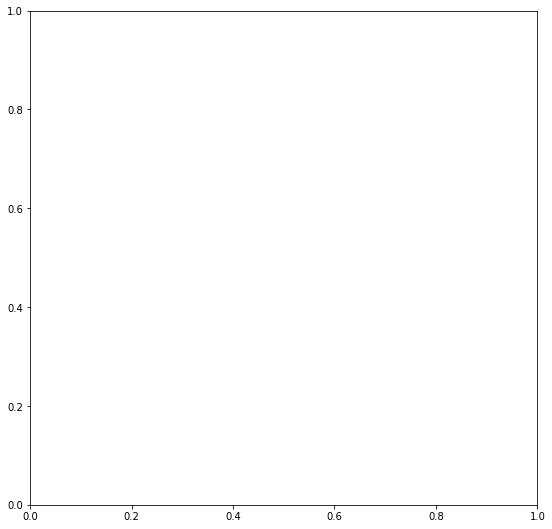

In [5]:
#display the ROI
plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(croppedImage)[12,:,:], cmap="gray")
plt.title("Bentheimer #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(croppedMask)[12,:,:])        
plt.title("ROI #1")